In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp
import numpy as np
from typing import List
import time

# 基本パラメータ
PERIOD = 7.2  # mm (1030nm位相整合波長)
TOTAL_DOMAINS = 600
DEVICE_LENGTH = PERIOD * TOTAL_DOMAINS / 2  # 大体10mm
KAPPA = 1.031E-05
WAVELENGTH_RANGE = jnp.linspace(1.02, 1.04, 500).tolist()  # 1030nm周辺の広帯域
TEMP = 20.0

# 帯域幅計算の基準設定
BANDWIDTH_THRESHOLD = 0.99  # 95%基準

# 調整層幅の範囲 (周期ベース)
ADJUST_WIDTH_MIN = PERIOD * 0.4   # 周期の0.4倍
ADJUST_WIDTH_MAX = PERIOD * 1.6   # 周期の1.6倍
NUM_WIDTH_STEPS = 1000

# 調整層位置の範囲 (1から599、最初と最後は除外)
ADJUST_POSITION_START = 1
ADJUST_POSITION_END = TOTAL_DOMAINS - 1

print(f"基本周期: {PERIOD:.1f} mm")
print(f"総ドメイン数: {TOTAL_DOMAINS}")
print(f"デバイス長: {DEVICE_LENGTH:.1f} mm")
print(
    f"計算波長範囲: {min(WAVELENGTH_RANGE):.3f} - {max(WAVELENGTH_RANGE):.3f} μm (1030nm周辺)")
print(f"帯域幅基準: {BANDWIDTH_THRESHOLD*100:.0f}%")
print(f"調整層幅範囲: {ADJUST_WIDTH_MIN:.2f} - {ADJUST_WIDTH_MAX:.2f} mm (周期の{ADJUST_WIDTH_MIN/PERIOD:.1f}倍～{ADJUST_WIDTH_MAX/PERIOD:.1f}倍)")
print(f"調整層位置範囲: {ADJUST_POSITION_START} - {ADJUST_POSITION_END}")
print(
    f"総探索パターン数: {NUM_WIDTH_STEPS * (ADJUST_POSITION_END - ADJUST_POSITION_START):.0f}")
print(
    f"\\n論文の最適値: 周期と同じ幅 = {PERIOD:.1f} mm, 位置 = 0.165L = {0.165*TOTAL_DOMAINS:.0f}番目のドメイン")

基本周期: 7.2 mm
総ドメイン数: 600
デバイス長: 2160.0 mm
計算波長範囲: 1.020 - 1.040 μm (1030nm周辺)
帯域幅基準: 99%
調整層幅範囲: 2.88 - 11.52 mm (周期の0.4倍～1.6倍)
調整層位置範囲: 1 - 599
総探索パターン数: 598000
\n論文の最適値: 周期と同じ幅 = 7.2 mm, 位置 = 0.165L = 99番目のドメイン


In [2]:
def create_two_segment_pros_all() -> shg.DomainTensor:
    """
    2セグメントPROS構造の全パターンを一度に生成

    Returns:
        DomainTensor (shape: total_patterns, TOTAL_DOMAINS, 2)
    """
    # 調整層幅と位置の配列を作成
    adjust_widths = jnp.linspace(
        ADJUST_WIDTH_MIN, ADJUST_WIDTH_MAX, NUM_WIDTH_STEPS)
    adjust_positions = jnp.arange(ADJUST_POSITION_START, ADJUST_POSITION_END)

    # メッシュグリッドで全組み合わせを作成
    width_grid, pos_grid = jnp.meshgrid(
        adjust_widths, adjust_positions, indexing='ij')
    width_flat = width_grid.flatten()  # (total_patterns,)
    pos_flat = pos_grid.flatten()      # (total_patterns,)

    total_patterns = len(width_flat)

    # 基本幅の配列を作成 (total_patterns, TOTAL_DOMAINS)
    base_widths = jnp.full((total_patterns, TOTAL_DOMAINS), PERIOD / 2)

    # 調整層位置のマスクを作成
    domain_indices = jnp.arange(TOTAL_DOMAINS)  # (TOTAL_DOMAINS,)
    # (total_patterns, TOTAL_DOMAINS)
    pos_mask = domain_indices[None, :] == pos_flat[:, None]

    # 調整層の幅を適用
    widths = jnp.where(pos_mask, width_flat[:, None], base_widths)

    # カッパ値を設定（偶数インデックス: +, 奇数インデックス: -）
    kappa_pattern = jnp.where(domain_indices % 2 == 0, KAPPA, -KAPPA)
    kappas = jnp.broadcast_to(kappa_pattern, (total_patterns, TOTAL_DOMAINS))

    # テンソルを作成
    tensor = jnp.stack([widths, kappas], axis=-1)
    return tensor


print("完全並列化された2セグメントPROS構造生成関数を定義しました")

完全並列化された2セグメントPROS構造生成関数を定義しました


In [3]:
# 全パターンを一度に生成
print("全パターンのPROS構造を生成中...")
start_time = time.time()

pros_tensor = create_two_segment_pros_all()

generation_time = time.time() - start_time
print(f"構造生成完了: {generation_time:.2f}秒")
print(f"生成されたテンソル形状: {pros_tensor.shape}")
print(f"メモリ使用量: {pros_tensor.nbytes / 1e9:.2f} GB")

# 調整層幅と位置の配列（後で結果分析に使用）
adjust_widths = jnp.linspace(
    ADJUST_WIDTH_MIN, ADJUST_WIDTH_MAX, NUM_WIDTH_STEPS)
adjust_positions = jnp.arange(ADJUST_POSITION_START, ADJUST_POSITION_END)
total_patterns = len(adjust_widths) * len(adjust_positions)

print(f"調整層幅パターン数: {len(adjust_widths)}")
print(f"調整層位置パターン数: {len(adjust_positions)}")
print(f"総パターン数: {total_patterns}")

全パターンのPROS構造を生成中...
構造生成完了: 0.75秒
生成されたテンソル形状: (598000, 600, 2)
メモリ使用量: 2.87 GB
調整層幅パターン数: 1000
調整層位置パターン数: 598
総パターン数: 598000


In [4]:
def calculate_bandwidth(efficiency_spectrum: jnp.ndarray, threshold: float = 0.5) -> float:
    """
    効率スペクトラムから帯域幅を計算

    Args:
        efficiency_spectrum: 効率スペクトラム配列
        threshold: 帯域幅計算の閾値（最大値に対する比率）

    Returns:
        帯域幅 (μm)
    """
    max_eff = jnp.max(efficiency_spectrum)
    above_threshold = efficiency_spectrum >= max_eff * threshold

    if jnp.sum(above_threshold) == 0:
        return 0.0

    # 閾値を超える波長範囲を計算
    wavelength_array = jnp.array(WAVELENGTH_RANGE)
    valid_wavelengths = wavelength_array[above_threshold]

    return jnp.max(valid_wavelengths) - jnp.min(valid_wavelengths)


print("帯域幅計算関数を定義しました")

帯域幅計算関数を定義しました


In [5]:
# 全パターンのSHG解析を一度に実行
print("全パターンのSHG解析を開始...")
start_time = time.time()

# SHG解析
shg_params = shg.Params(
    grating_dim=pros_tensor,
    T_dim=[TEMP],
    wavelength_dim=WAVELENGTH_RANGE,
    fund_power_dim=1,
    sh_power_dim=0
)

eff_tensor = shg.analyze(shg_params, mgoslt.use_material, shg.solve_ncme_npda)
power = jnp.abs(eff_tensor[:, 0, :, 0, 0])**2

analysis_time = time.time() - start_time
print(f"SHG解析完了: {analysis_time:.2f}秒")
print(f"効率テンソル形状: {power.shape}")

# 各パターンの最大効率
max_efficiencies = jnp.max(power, axis=1)

# 修正された評価関数（正規化基準を保存）


def calculate_vectorized_metrics_fixed(power_matrix: jnp.ndarray, threshold: float = BANDWIDTH_THRESHOLD,
                                       global_max_eff: float = None, global_max_bw: float = None) -> tuple:
    """
    修正版: 正規化基準を外部から指定可能
    """
    # 各パターンの最大値
    max_effs = jnp.max(power_matrix, axis=1, keepdims=True)  # (N, 1)

    # 閾値を超える波長のマスク
    above_threshold = power_matrix >= max_effs * threshold  # (N, W)

    # 1. 実効帯域幅（閾値を超える点の密度を考慮）
    wavelength_step = (max(WAVELENGTH_RANGE) -
                       min(WAVELENGTH_RANGE)) / len(WAVELENGTH_RANGE)
    effective_bandwidth = jnp.sum(above_threshold, axis=1) * wavelength_step

    # 2. 平坦性スコア（ベクトル化版）
    has_valid_points = jnp.sum(above_threshold, axis=1) > 0  # (N,)
    valid_power_sum = jnp.sum(
        jnp.where(above_threshold, power_matrix, 0.0), axis=1)
    valid_power_mean = jnp.where(has_valid_points,
                                 valid_power_sum /
                                 jnp.sum(above_threshold, axis=1),
                                 0.0)

    # 分散計算
    squared_diff = jnp.where(above_threshold,
                             (power_matrix - valid_power_mean[:, None])**2,
                             0.0)
    valid_power_var = jnp.where(has_valid_points,
                                jnp.sum(squared_diff, axis=1) /
                                jnp.sum(above_threshold, axis=1),
                                jnp.inf)

    # 正規化分散の逆数（平坦性スコア）
    normalized_std = jnp.sqrt(valid_power_var) / (valid_power_mean + 1e-10)
    flatness_score = jnp.where(
        has_valid_points, 1.0 / (1.0 + normalized_std), 0.0)

    # 3. 複合スコア（修正版：グローバル基準で正規化）
    if global_max_eff is None:
        global_max_eff = jnp.max(max_effs)
    if global_max_bw is None:
        global_max_bw = jnp.max(effective_bandwidth)

    # グローバル基準で正規化
    norm_eff_bw = effective_bandwidth / (global_max_bw + 1e-10)
    norm_flatness = flatness_score  # 平坦性は0-1の範囲なので正規化不要
    norm_efficiency = max_effs.squeeze() / global_max_eff

    # 重み付き複合スコア
    composite_score = (norm_eff_bw**0.4) * \
        (norm_flatness**0.3) * (norm_efficiency**0.3)

    return effective_bandwidth, flatness_score, composite_score


# まず全バッチで計算して正規化基準を取得
effective_bandwidths, flatness_scores, _ = calculate_vectorized_metrics_fixed(
    power, BANDWIDTH_THRESHOLD)
global_max_eff = jnp.max(max_efficiencies)
global_max_bw = jnp.max(effective_bandwidths)

print(f"正規化基準: 最大効率={global_max_eff:.8f}, 最大帯域幅={global_max_bw*1000:.1f}nm")

# 正規化基準を固定して再計算
_, _, composite_scores = calculate_vectorized_metrics_fixed(
    power, BANDWIDTH_THRESHOLD, global_max_eff, global_max_bw)

print(f"計算完了: 修正版評価指標を算出")
print(f"- 実効帯域幅最大: {global_max_bw*1000:.1f} nm")
print(f"- 平坦性スコア最大: {jnp.max(flatness_scores):.3f}")
print(f"- 複合スコア最大: {jnp.max(composite_scores):.3f}")

# 再利用可能な評価関数として定義


def calculate_single_metrics(power_spectrum: jnp.ndarray) -> tuple:
    """単体スペクトラム用の評価関数（グローバル基準使用）"""
    return calculate_vectorized_metrics_fixed(power_spectrum[None, :], BANDWIDTH_THRESHOLD, global_max_eff, global_max_bw)

全パターンのSHG解析を開始...
SHG解析完了: 5.61秒
効率テンソル形状: (598000, 500)
正規化基準: 最大効率=0.00020100, 最大帯域幅=0.8nm
計算完了: 修正版評価指標を算出
- 実効帯域幅最大: 0.8 nm
- 平坦性スコア最大: 1.000
- 複合スコア最大: 0.784


In [6]:
# 結果の分析（複合スコア基準で最適化）
best_idx = jnp.argmax(composite_scores)  # 複合スコアで選択
best_composite_score = composite_scores[best_idx]
best_effective_bandwidth = effective_bandwidths[best_idx]
best_flatness_score = flatness_scores[best_idx]
best_efficiency = max_efficiencies[best_idx]

# 最適パラメータを逆算
width_idx = best_idx // len(adjust_positions)
pos_idx = best_idx % len(adjust_positions)
best_width = adjust_widths[width_idx]
best_position = adjust_positions[pos_idx]
best_spectrum = power[best_idx, :]

print("=== 最適化結果（複合スコア基準） ===")
print(f"最高複合スコア: {best_composite_score:.6f}")
print(
    f"実効帯域幅: {best_effective_bandwidth:.6f} μm ({best_effective_bandwidth*1000:.1f} nm)")
print(f"平坦性スコア: {best_flatness_score:.6f}")
print(f"効率: {best_efficiency:.8f}")
print(f"最適調整層幅: {best_width:.6f} mm ({best_width/PERIOD:.3f} × 周期)")
print(
    f"最適調整層位置: {best_position} (ドメインインデックス, {best_position/TOTAL_DOMAINS:.3f}L)")

# 他の基準での最適解も表示（比較用）
eff_bw_best_idx = jnp.argmax(effective_bandwidths)
efficiency_best_idx = jnp.argmax(max_efficiencies)
flatness_best_idx = jnp.argmax(flatness_scores)

print(f"\n=== 他の基準での最適解（比較用） ===")
print(
    f"実効帯域幅最大: {effective_bandwidths[eff_bw_best_idx]*1000:.1f} nm (複合スコア: {composite_scores[eff_bw_best_idx]:.6f})")
print(
    f"効率最大: {max_efficiencies[efficiency_best_idx]:.8f} (複合スコア: {composite_scores[efficiency_best_idx]:.6f})")
print(
    f"平坦性最大: {flatness_scores[flatness_best_idx]:.6f} (複合スコア: {composite_scores[flatness_best_idx]:.6f})")

# 統計情報
print(f"\n=== 統計情報 ===")
print(f"実効帯域幅の平均: {jnp.mean(effective_bandwidths)*1000:.1f} nm")
print(f"実効帯域幅の最大値: {jnp.max(effective_bandwidths)*1000:.1f} nm")
print(f"平坦性スコアの平均: {jnp.mean(flatness_scores):.6f}")
print(f"平坦性スコアの最大値: {jnp.max(flatness_scores):.6f}")
print(f"複合スコアの平均: {jnp.mean(composite_scores):.6f}")
print(f"複合スコアの最大値: {jnp.max(composite_scores):.6f}")

# 論文条件との比較
paper_optimal_position = int(0.165 * TOTAL_DOMAINS)
width_ratios = jnp.linspace(ADJUST_WIDTH_MIN/PERIOD,
                            ADJUST_WIDTH_MAX/PERIOD, NUM_WIDTH_STEPS)
closest_width_idx = jnp.argmin(jnp.abs(width_ratios - 1.0))
paper_width = adjust_widths[closest_width_idx]

print(f"\n=== 論文条件との比較 ===")
print(f"論文最適条件: 幅={PERIOD:.1f}mm (周期×1.0), 位置={paper_optimal_position} ({paper_optimal_position/TOTAL_DOMAINS:.3f}L)")
print(f"探索最適条件: 幅={best_width:.1f}mm (周期×{best_width/PERIOD:.3f}), 位置={best_position} ({best_position/TOTAL_DOMAINS:.3f}L)")

if abs(best_width - PERIOD) < 0.5 and abs(best_position - paper_optimal_position) < 10:
    print("✅ 探索結果は論文条件に近い！")
else:
    print("❌ 探索結果は論文条件と異なる")

=== 最適化結果（複合スコア基準） ===
最高複合スコア: 0.783953
実効帯域幅: 0.000760 μm (0.8 nm)
平坦性スコア: 0.997206
効率: 0.00008954
最適調整層幅: 7.204325 mm (1.001 × 周期)
最適調整層位置: 499 (ドメインインデックス, 0.832L)

=== 他の基準での最適解（比較用） ===
実効帯域幅最大: 0.8 nm (複合スコア: 0.783953)
効率最大: 0.00020100 (複合スコア: 0.477627)
平坦性最大: 1.000000 (複合スコア: 0.347085)

=== 統計情報 ===
実効帯域幅の平均: 0.1 nm
実効帯域幅の最大値: 0.8 nm
平坦性スコアの平均: 0.997120
平坦性スコアの最大値: 1.000000
複合スコアの平均: 0.464400
複合スコアの最大値: 0.783953

=== 論文条件との比較 ===
論文最適条件: 幅=7.2mm (周期×1.0), 位置=99 (0.165L)
探索最適条件: 幅=7.2mm (周期×1.001), 位置=499 (0.832L)
❌ 探索結果は論文条件と異なる


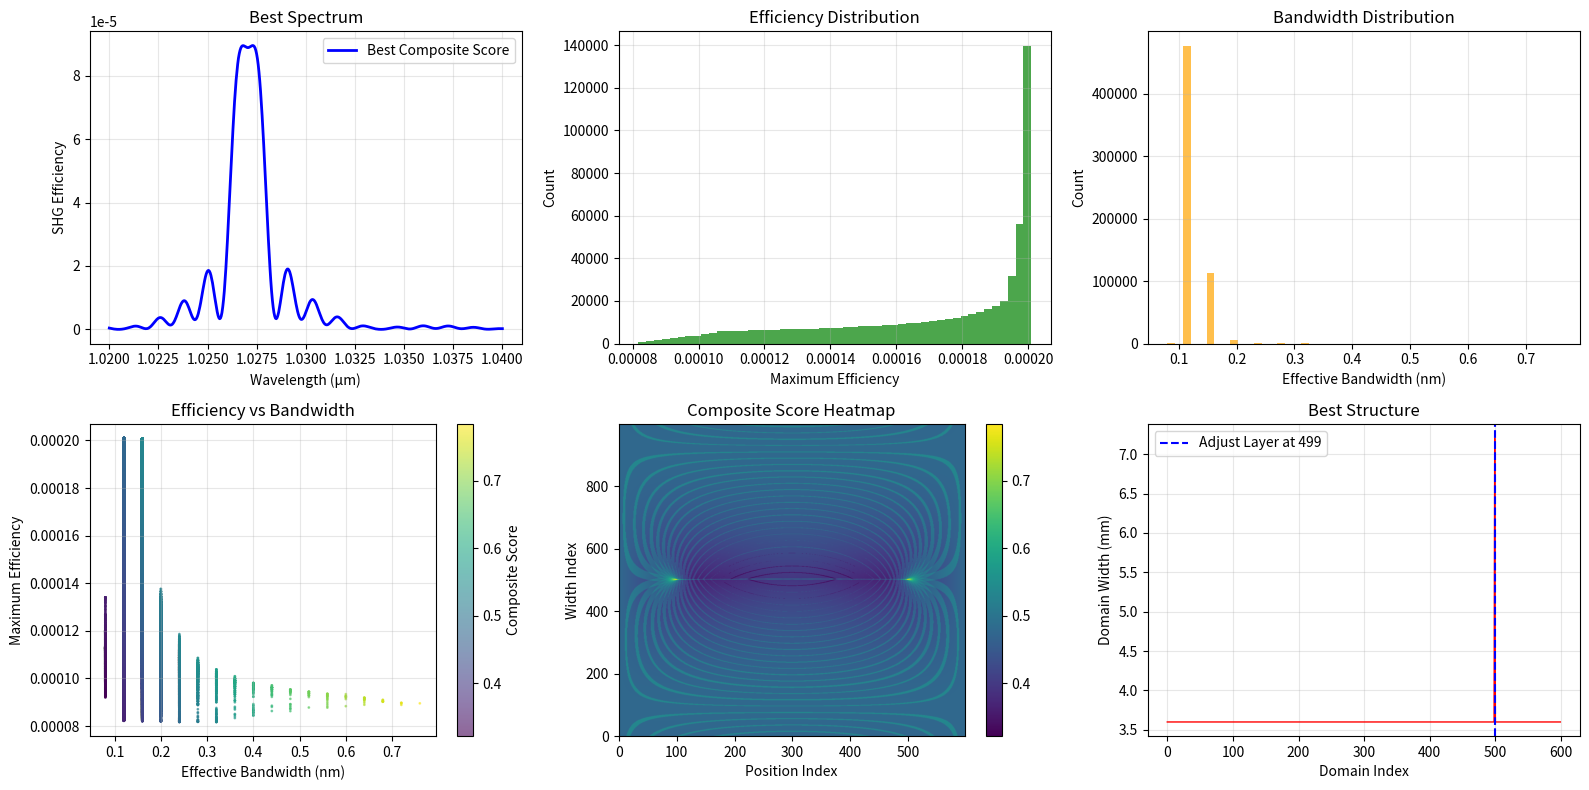

In [7]:
# 結果の可視化（シンプル版）
fig = plt.figure(figsize=(16, 8))

# 1. 最適スペクトラム
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(WAVELENGTH_RANGE, best_spectrum, 'b-',
         linewidth=2, label='Best Composite Score')
ax1.set_xlabel('Wavelength (μm)')
ax1.set_ylabel('SHG Efficiency')
ax1.set_title('Best Spectrum')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 効率分布
ax2 = fig.add_subplot(2, 3, 2)
ax2.hist(max_efficiencies, bins=50, alpha=0.7, color='green')
ax2.set_xlabel('Maximum Efficiency')
ax2.set_ylabel('Count')
ax2.set_title('Efficiency Distribution')
ax2.grid(True, alpha=0.3)

# 3. 実効帯域幅分布
ax3 = fig.add_subplot(2, 3, 3)
ax3.hist(effective_bandwidths*1000, bins=50, alpha=0.7, color='orange')
ax3.set_xlabel('Effective Bandwidth (nm)')
ax3.set_ylabel('Count')
ax3.set_title('Bandwidth Distribution')
ax3.grid(True, alpha=0.3)

# 4. 効率 vs 実効帯域幅の散布図
ax4 = fig.add_subplot(2, 3, 4)
scatter = ax4.scatter(effective_bandwidths*1000, max_efficiencies, c=composite_scores,
                      cmap='viridis', alpha=0.6, s=1)
ax4.set_xlabel('Effective Bandwidth (nm)')
ax4.set_ylabel('Maximum Efficiency')
ax4.set_title('Efficiency vs Bandwidth')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Composite Score')

# 5. 複合スコアのヒートマップ
ax5 = fig.add_subplot(2, 3, 5)
score_reshaped = composite_scores.reshape(
    len(adjust_widths), len(adjust_positions))
im = ax5.imshow(score_reshaped, aspect='auto', cmap='viridis', origin='lower')
ax5.set_xlabel('Position Index')
ax5.set_ylabel('Width Index')
ax5.set_title('Composite Score Heatmap')
plt.colorbar(im, ax=ax5)

# 6. 最適構造
ax6 = fig.add_subplot(2, 3, 6)
best_structure = pros_tensor[best_idx, :, 0]
ax6.plot(range(TOTAL_DOMAINS), best_structure, 'r-', linewidth=1)
ax6.axvline(x=best_position, color='blue', linestyle='--',
            label=f"Adjust Layer at {best_position}")
ax6.set_xlabel('Domain Index')
ax6.set_ylabel('Domain Width (mm)')
ax6.set_title('Best Structure')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== 修正後の論文条件検証 ===
論文条件: 幅=7.2mm, 位置=99
探索点: 幅=7.196mm, 位置=99

修正後の探索結果での論文条件:
- 最大効率: 0.00009038
- 実効帯域幅: 0.7 nm
- 平坦性スコア: 0.997600
- 複合スコア: 0.752028

単体再計算（修正版）:
- 最大効率: 0.00009038
- 実効帯域幅: 0.7 nm
- 平坦性スコア: 0.997600
- 複合スコア: 0.752028

スコアの差: 0.00000000
✅ 修正成功！探索結果と再計算が一致

=== 最適解の確認 ===
新しい最適インデックス: 299498
新しい最適複合スコア: 0.783953
論文条件の複合スコア: 0.752028
✅ 論文条件は上位の解です
論文条件のランキング: 10/598000 (上位0.00%)


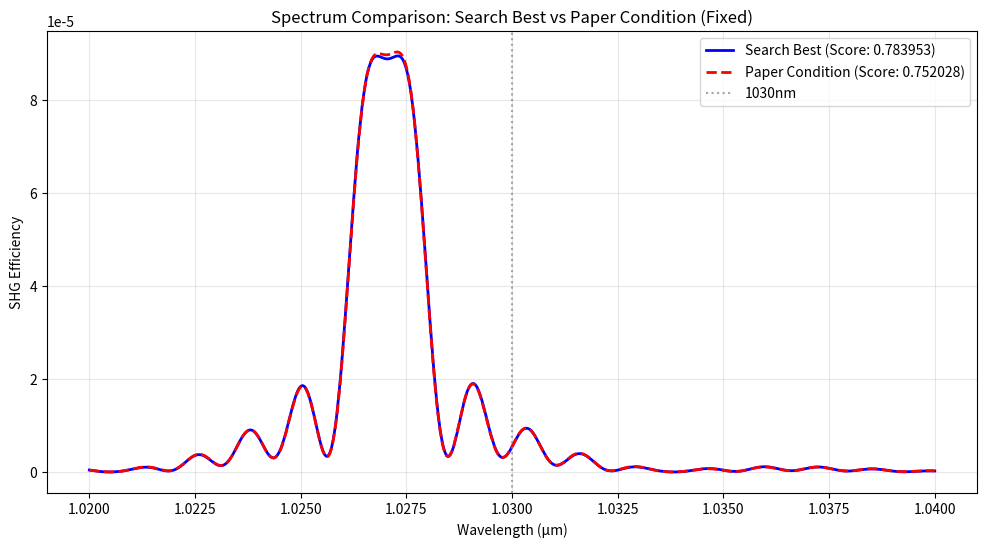

In [8]:
# 修正後の論文条件検証
print("=== 修正後の論文条件検証 ===")

# 論文条件のインデックス
paper_optimal_position = int(0.165 * TOTAL_DOMAINS)
width_ratios = jnp.linspace(ADJUST_WIDTH_MIN/PERIOD,
                            ADJUST_WIDTH_MAX/PERIOD, NUM_WIDTH_STEPS)
closest_width_idx = jnp.argmin(jnp.abs(width_ratios - 1.0))
closest_pos_idx = jnp.argmin(
    jnp.abs(adjust_positions - paper_optimal_position))
paper_test_idx = closest_width_idx * len(adjust_positions) + closest_pos_idx

print(f"論文条件: 幅={PERIOD:.1f}mm, 位置={paper_optimal_position}")
print(
    f"探索点: 幅={adjust_widths[closest_width_idx]:.3f}mm, 位置={adjust_positions[closest_pos_idx]}")

# 探索結果から論文条件の評価を取得
paper_search_eff = max_efficiencies[paper_test_idx]
paper_search_eff_bw = effective_bandwidths[paper_test_idx]
paper_search_flatness = flatness_scores[paper_test_idx]
paper_search_composite = composite_scores[paper_test_idx]

print(f"\n修正後の探索結果での論文条件:")
print(f"- 最大効率: {paper_search_eff:.8f}")
print(f"- 実効帯域幅: {paper_search_eff_bw*1000:.1f} nm")
print(f"- 平坦性スコア: {paper_search_flatness:.6f}")
print(f"- 複合スコア: {paper_search_composite:.6f}")

# 単体で再計算（修正版関数使用）
paper_spectrum = power[paper_test_idx, :]
paper_single_eff_bw, paper_single_flatness, paper_single_composite = calculate_single_metrics(
    paper_spectrum)

print(f"\n単体再計算（修正版）:")
print(f"- 最大効率: {jnp.max(paper_spectrum):.8f}")
print(f"- 実効帯域幅: {paper_single_eff_bw[0]*1000:.1f} nm")
print(f"- 平坦性スコア: {paper_single_flatness[0]:.6f}")
print(f"- 複合スコア: {paper_single_composite[0]:.6f}")

# 一致確認
score_diff = abs(paper_search_composite - paper_single_composite[0])
print(f"\nスコアの差: {score_diff:.8f}")

if score_diff < 1e-6:
    print("✅ 修正成功！探索結果と再計算が一致")
else:
    print("❌ まだ問題が残っている")

# 最適解の更新確認
best_idx_new = jnp.argmax(composite_scores)
best_composite_new = composite_scores[best_idx_new]

print(f"\n=== 最適解の確認 ===")
print(f"新しい最適インデックス: {best_idx_new}")
print(f"新しい最適複合スコア: {best_composite_new:.6f}")
print(f"論文条件の複合スコア: {paper_search_composite:.6f}")

if paper_test_idx == best_idx_new:
    print("🎉 論文条件が最適解として選ばれました！")
elif paper_search_composite > best_composite_new * 0.95:
    print("✅ 論文条件は上位の解です")

    # 論文条件のランキング
    ranking = jnp.sum(composite_scores >= paper_search_composite)
    total_patterns = len(composite_scores)
    print(
        f"論文条件のランキング: {ranking}/{total_patterns} (上位{ranking/total_patterns*100:.2f}%)")
else:
    print("❓ 論文条件より良い解が存在します")

# スペクトル比較（最適解が変わった場合の更新）
best_spectrum_new = power[best_idx_new, :]

plt.figure(figsize=(12, 6))
plt.plot(WAVELENGTH_RANGE, best_spectrum_new, 'b-', linewidth=2,
         label=f'Search Best (Score: {best_composite_new:.6f})')
plt.plot(WAVELENGTH_RANGE, paper_spectrum, 'r--', linewidth=2,
         label=f'Paper Condition (Score: {paper_search_composite:.6f})')
plt.axvline(x=1.030, color='gray', linestyle=':', alpha=0.7, label='1030nm')
plt.xlabel('Wavelength (μm)')
plt.ylabel('SHG Efficiency')
plt.title('Spectrum Comparison: Search Best vs Paper Condition (Fixed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()